# Import Dependencies


In [28]:
import tweepy
import json
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import time

# Set up API keys and authentication

In [29]:
#API Keys for owner yydata_PlotBot
consumer_key = "6dj1rPeIXm9lGHAJ0XDOlBCKT"
consumer_secret = "Czsnhwgan8wDkShkWclER9XNcpurhJFWmCBaC5EvVv5BcKPhHV"
access_token = "968998318780174336-zgI9bmi7Oaf3FbpeaIP6SxpFN85LewW"
access_token_secret ="kttUSYIn0NmynHBswVRehSC0BBV2akgqk4hfQ6i5VlFK7"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)#,parser=tweepy.parsers.JSONParser())


# plotbot function:
 receive tweet to '@yydata_PlotBot' for a sentimental analysis record and tweet back the requester the analysis graph 
 When you run the script,please try:
 Tweet me Analyze:id/name/screen name for sentimental score analysis
 
 Note: 1. No tweet will be sent if the requested search target has been searched before
       2. id/name/screen name to analyze needs to be put in the format Analyze:id/name/screen (must be after ':') 
       3. all searches have been done are updated and output to a request_log.csv
     

In [33]:
def plotbot():
    #read saved search_record into pd.dataframe
    search_record=pd.read_csv('request_log.csv')

    #find the most recent tweet_id in the search_record and assign it as the max_id 
    max_id=search_record['tweet_id'].max()

    #plobot_id(my bot screen name)
    plotbot_id='@yydata_PlotBot'

    #retrive new tweets every since the most recent tweet_id
    tweets_to_me =tweepy.Cursor(api.search,q=plotbot_id,result_type="recent",lang='en',since_id=max_id).items()

    #use a list to store tweet_text,tweet_id, and sn_requester (the screen name of the requester)
    tweet_text=[]
    tweet_id=[]
    sn_requester=[] 

    #extract tweet_text, tweet_id and screen name of the requester
    for tweet in tweets_to_me:
        tweet_text.append(tweet.text)
        tweet_id.append(tweet.id)
        sn_requester.append(tweet.user.screen_name)
        #if no more updates, tweet_id list will be empty []
        #if there are updates,tweet_id list will not be empty

    #extract all the targets that have been searched out from the record dataframe as a list 
    searched_list=search_record['search_target'].values.tolist()

    #initiate new_rows which will be added to the record dataframe
    new_rows=[]

    #if there are new tweets(if there is no new tweet eversince last search tweet_text,tweet_id, sn_requester will still
    #be an empty list)
    if bool(tweet_id)==True:
        
        #Code below is to a:extract the search target from the tweet_text
                        # b:decide if the search target that has not been searched before
            #             c:save the new search target information as a new dataframe
            #             d: append the new dataframe to the search record and output the updated search_record as csv
        
    
        #use a while loop to extract the info of new search target
        #start a counter
        i=0
        while i < len(tweet_text):
        #extract strings after ':'.eg. '@yydata_PlotBot Analyze:id/name/screen_name' get the 'id/name/screen_name'
        #only proceed when the following conditions are met
            #a.being able to extract id/name/screen_name
            #b.this id/name/screen_name have not been searched before
            if (bool(re.findall(r'(?<=:)[@\w]+', tweet_text[i]))==True and re.findall(r'(?<=:)[@\w]+', tweet_text[i])[0]\
                not in searched_list):
#                 print('the current searched_list is {}'.format(searched_list))
#                 print('we have a unique target {}'.format(tweet_text[i]))
                
                # re.findall returns a list;
                #for this case only one element is in list(unless someone tweet me two names in one tweet, then I am only
                #going to analyze the first one)
                search_target=re.findall(r'(?<=:)[@\w]+', tweet_text[i])[0]
#                 print(search_target)
                
                #extract corresponding screen_name, tweet_id of the new search_target
                new_sn=sn_requester[i]
#                 print(new_sn)
                new_tweet_id=tweet_id[i]
#                 print(new_tweet_id)
                #append all the info of the new search_target into new_rows(so I can make new dataframe and append to the
                #search record)
                new_rows.append([search_target,new_sn,new_tweet_id])
#                 print('new_rows is {}\n'.format(new_rows))
                
                #append this new target to the searched_list 
                searched_list.append(search_target)
#                 print('current searched_list is {}'.format(searched_list))
                
            else:
                print('No id is found or i have searched this before {}'.format(tweet_text[i]))
            i+=1
        #check if there are any new valid targets if there are new_rows=[[search_target,new_sn,new_tweet_id],,,]
        #if no new valid target name has been retrieved  new_rows=[[]] 
        if new_rows!=[[]]:
            #make a new_df if there are new targets and append it to the search_record
            new_df=pd.DataFrame(new_rows,columns=['search_target','sn_requester','tweet_id'])
#             print('new_df is {}'.format(new_df))
            search_record=search_record.append(new_df, ignore_index=True)
#             print('current search_record is {}'.format(search_record))
            
            #Save the updated search onto the request_log.csv
            search_record.to_csv('request_log.csv',index=False)
            
            #code below is to plot and update
            analyzer = SentimentIntensityAnalyzer()
            
            #define a variable to store # of tweets to retrieve
            max_item=500
            for i in new_df['search_target'].values.tolist():
                try:
#                 print(i)
                    target_tweets=tweepy.Cursor(api.user_timeline,id=i,result_type="recent").items(max_item)
                    tweets_list=[tweet.text for tweet in target_tweets]
                    compound = [analyzer.polarity_scores(i)["compound"] for i in tweets_list]
                    sentiment, =plt.plot(np.arange(0,len(compound),1),compound,marker="o", linewidth=0.5, alpha=0.8,label=i)
                    # # Incorporate the other graph properties
                    plt.title("Sentiment Analysis of Tweets (%s) for %s" % (time.strftime("%x"), i))
                    plt.ylabel("Tweet Polarity")
                    plt.xlabel("Tweets Ago")
                    plt.legend(handles=[sentiment], loc="best")
                    filepath='output/'+i+'.png'
                    plt.savefig(filepath)
                    plt.show()
                    #code below is to update the information to the requester
                    respond_id=new_df.loc[new_df["search_target"] == i, "tweet_id"].values[0]
                    respond_sn=new_df.loc[new_df["search_target"] ==i ,'sn_requester'].values[0]
                    api.update_with_media(filepath,"thanks @{} for your request".format(respond_sn),in_reply_to_status_id = respond_id)
                    print('New graph has been sent') 
                except tweepy.TweepError as e:
                    print(e)
                    pass
        
        else:
            print('no new valid id has been retrieved ever since last search {}'.format(max_id))
        
    else:
        print('no new tweet since last search {}'.format(max_id))
                #see if the target has been searched already

No id is found or i have searched this before @yydata_PlotBot  Analyze:'''''''''
No id is found or i have searched this before @yydata_PlotBot Analyze:''''''
No id is found or i have searched this before @yydata_PlotBot Analyze:


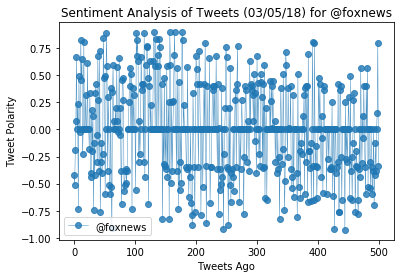

New graph has been sent
no new tweet since last search 970742808272351233
no new tweet since last search 970742808272351233
no new tweet since last search 970742808272351233
no new tweet since last search 970742808272351233


In [34]:
#File to server
counter=0
while True:
    plotbot()
    time.sleep(300)
    counter+=1
    print('currently I have ran {}'.format(counter))